Задача: предсказать следующие N значений временного ряда. В этом примере генерируется синусоида произвольной длины со случайным значением аплитуды и частоты. Мы хотим предсказать следующие 30 значений

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def gen_data(batch = 16):
    
    t = np.arange(0,torch.randint(5,15,(1,)),step=0.1)
    X = torch.zeros(t.size-30,batch,1)
    Y = torch.zeros(30,batch,1)
    
    for i in range(batch):
        a = torch.rand(1)*3 + 0.1
        
        b = torch.rand(1)*4 + 0.2
        
        #X[i,:,0] =  torch.tensor(t)
        y = a*np.sin(b*t)
        X[:,i,0] =  y[:-30]
        Y[:,i,0] = y[-30:]
    return X,Y

In [5]:
device = 'cpu'


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import Tensor
from typing import Optional
import math

class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TransformerSeq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, num_heads=8, dropout=0.1):
        super(TransformerSeq2Seq, self).__init__()
        self.src_embed = nn.Linear(input_size, hidden_size)
        self.tgt_embed = nn.Linear(output_size, hidden_size)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads,
                                                   dropout=dropout, dim_feedforward=256)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads,
                                                   dropout=dropout, dim_feedforward=256)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        
        self.pos_enc = PositionalEncoding(emb_size=hidden_size, dropout=dropout)

        
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, src: Tensor, tgt: Tensor, tgt_mask: Optional[Tensor] = None):
        src = self.src_embed(src)
        src = self.pos_enc(src)
        tgt = self.tgt_embed(tgt)
        tgt = self.pos_enc(tgt)
        
        tgt_mask = torch.nn.Transformer().generate_square_subsequent_mask(
                tgt.size(0))
        
        encoder_outputs = self.encoder(src)
        decoder_outputs = self.decoder(tgt, encoder_outputs, tgt_mask=tgt_mask)
        
        output = self.linear(decoder_outputs)
        
        return output, tgt_mask

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import Tensor
from typing import Optional
import math

class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TransformerSeq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, num_heads=4, dropout=0.1):
        super(TransformerSeq2Seq, self).__init__()
        self.src_embed = nn.Linear(input_size, hidden_size)
        self.tgt_embed = nn.Linear(output_size, hidden_size)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads,
                                                   dropout=dropout, dim_feedforward=64)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads,
                                                   dropout=dropout, dim_feedforward=64)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        
        self.pos_enc = PositionalEncoding(emb_size=hidden_size, dropout=dropout)

        
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, src: Tensor, tgt: Tensor, tgt_mask: Optional[Tensor] = None):
        src = self.src_embed(src)
        src = self.pos_enc(src)
        tgt = self.tgt_embed(tgt)
        tgt = self.pos_enc(tgt)
        
        tgt_mask = torch.nn.Transformer().generate_square_subsequent_mask(
                tgt.size(0))
        
        encoder_outputs = self.encoder(src)
        decoder_outputs = self.decoder(tgt, encoder_outputs, tgt_mask=tgt_mask)
        
        output = self.linear(decoder_outputs)
        
        return output, tgt_mask

In [55]:
model_seq = TransformerSeq2Seq(input_size=1, hidden_size=16, output_size=1)
x,y = gen_data(batch = 16)
output = model_seq(x,y)

In [56]:
import torch.optim as optim
criterion = nn.MSELoss()
# optimizer = optim.Adam(model_seq.parameters(), lr=0.0001, weight_decay=0.01)
optimizer = optim.Adam(model_seq.parameters(), lr=0.001)

# Обучение модели
s = []
num_epochs = 4000
model_seq.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    input_sequence,target_sequence =  gen_data(batch=16)

    # Перекидываем последний элемент input_sequence в начало target_sequence
    # (необязательно на обучении, тк по факту ничего не меняется)
    target_sequence = torch.cat([input_sequence[-1, :, :].reshape(-1, 16, 1), target_sequence])
    input_sequence = input_sequence[:-1]

    output, _ = model_seq(input_sequence,target_sequence)
    
    loss = criterion(output[:-1], target_sequence[1:])
    loss.backward()
    optimizer.step()
    s.append(loss.detach().to('cpu'))

    if (epoch + 1) % 20 == 0:
        S = np.mean(s)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {S:.4f}')
        s = []


Epoch [20/4000], Loss: 0.4936
Epoch [40/4000], Loss: 0.2596
Epoch [60/4000], Loss: 0.2121
Epoch [80/4000], Loss: 0.1737
Epoch [100/4000], Loss: 0.1403
Epoch [120/4000], Loss: 0.1434
Epoch [140/4000], Loss: 0.1277
Epoch [160/4000], Loss: 0.1172
Epoch [180/4000], Loss: 0.1151
Epoch [200/4000], Loss: 0.1174
Epoch [220/4000], Loss: 0.0919
Epoch [240/4000], Loss: 0.1101
Epoch [260/4000], Loss: 0.1009
Epoch [280/4000], Loss: 0.0891
Epoch [300/4000], Loss: 0.0878
Epoch [320/4000], Loss: 0.0818
Epoch [340/4000], Loss: 0.0806
Epoch [360/4000], Loss: 0.0949
Epoch [380/4000], Loss: 0.0702
Epoch [400/4000], Loss: 0.0856
Epoch [420/4000], Loss: 0.0807
Epoch [440/4000], Loss: 0.0836
Epoch [460/4000], Loss: 0.0782
Epoch [480/4000], Loss: 0.0732
Epoch [500/4000], Loss: 0.0775
Epoch [520/4000], Loss: 0.0720
Epoch [540/4000], Loss: 0.0694
Epoch [560/4000], Loss: 0.0677
Epoch [580/4000], Loss: 0.0663
Epoch [600/4000], Loss: 0.0650
Epoch [620/4000], Loss: 0.0638
Epoch [640/4000], Loss: 0.0588
Epoch [660/4

In [58]:
model_seq.eval()
print()

In [59]:
input_sequence, _ =  gen_data(batch=16)

# Задаем начальный элемент target_sequence как последний из input_sequence
target_sequence = torch.cat([input_sequence[-1, :, :].reshape(-1, 16, 1), torch.randn([29, 16, 1])])

for i in range(29):
    output, _ = model_seq(input_sequence[:-1], target_sequence)
    target_sequence[i + 1, :, :] = output[i, :, :].detach()

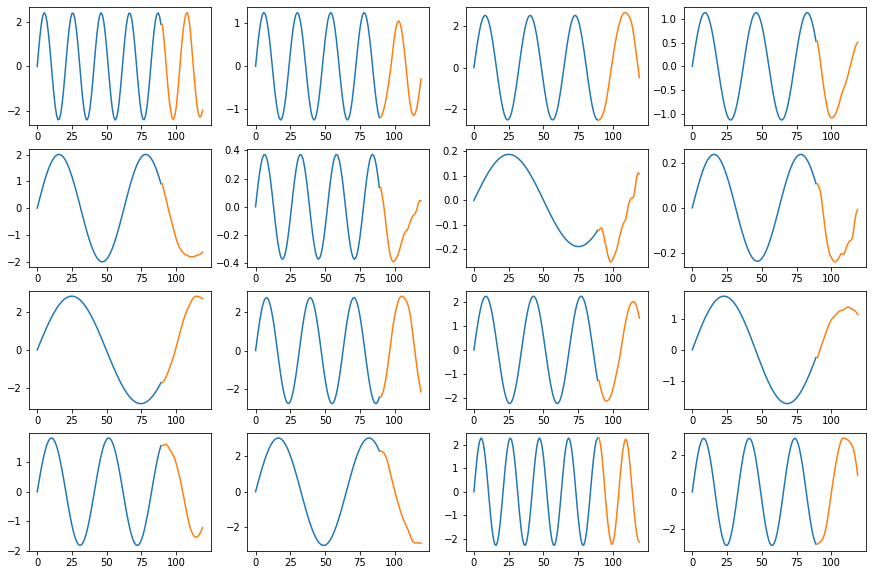

In [60]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10)) # , sharey=True, sharex=True)

for i in range(16):
    axes[i // 4, i % 4].plot(input_sequence[:, i, 0])
    axes[i // 4, i % 4].plot(np.arange(30) + len(input_sequence), target_sequence[:, i, 0])